# Homework

You need to train the model and get score as big as you can

Dataset: https://disk.yandex.ru/d/gcGKZ_KsXZN4VA

### Prepare part

In [1]:
import logging
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib
from torcheval.metrics import MulticlassAccuracy

from IPython.display import clear_output

%matplotlib inline

In [2]:
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/gcGKZ_KsXZN4VA'
# final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']
# !wget -O data.tar.gz "{download_url}"
# !tar -xf data.tar.gz

In [3]:
DEVICE = 'cuda' # also you can use "cuda" for gpu and "mps" for apple silicon
# DATADIR = '/mnt/hdd2/garage/ml_trains_data'
# DATADIR = 'ml_trains_data'
DATADIR = '/mnt/f/Temp/ml_trains_data'
# DATADIR = '/mnt/c/temp/ml_trains_data'
LOADER_WORKERS = 0

In [4]:
class Dataset(torch_data.Dataset):
    def __init__(self, split_part: str, datadir: str, feats: nn.Module, read_labels=True):
        super().__init__()
        data = pd.read_csv(os.path.join(datadir, f'{split_part}.tsv'), sep='\t') #[:100]
        if read_labels:
            labels = {key: idx for idx, key in enumerate(sorted(set(data.label.values)))}
            self._idx_to_label = {idx: key for idx, key in enumerate(sorted(set(data.label.values)))}
            self._classes = len(labels)
#             self._classes = 30
        self._feats = feats
        self._ytids = []
        self._pathes = []
        self._labels = []
        self.data = []
        for _, row in tqdm.tqdm(data.iterrows()):
            path = os.path.join(datadir, 'clips', f'{row.YTID}.flac')
            if os.path.exists(path):
                self._ytids.append(row.YTID)
                self._pathes.append(path)
                self._labels.append(labels[row.label] if read_labels else 0)
        for index in tqdm.tqdm(range(len(self._pathes))):
            self.data.append(torchaudio.load(self._pathes[index])[0])
#         self.data = [torchaudio.load(self._pathes[index]) for index in range(len(self._pathes))]
        
    def __getitem__(self, index):
#         try:
#             waveform, sample_rate = torchaudio.load(self._pathes[index])
#         except Exception as err:
#             logging.error("Can't read file %s", self._pathes[index])
#             raise err
#         waveform, sample_rate = self.data[index]
        waveform = self.data[index].clone()
#         waveform = waveform.clone()
#         assert sample_rate == 16000
        assert waveform.shape[0] == 1
        feats = self._feats(waveform)[0]
        return (feats, self._labels[index])
    
#     def __getitem__(self, index):
#         try:
#             waveform, sample_rate = torchaudio.load(self._pathes[index])
#         except Exception as err:
#             logging.error("Can't read file %s", self._pathes[index])
#             raise err
#         assert sample_rate == 16000
#         assert waveform.shape[0] == 1
#         feats = self._feats(waveform)[0]
#         return (feats, self._labels[index])

    def __len__(self) -> int:
        return len(self._pathes)

    def classes(self) -> int:
        return self._classes


def collate_fn(batch):
    max_length = max(item[0].shape[1] for item in batch)
    X = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    for idx, item in enumerate(batch):
        X[idx, :, :item[0].shape[1]] = item[0]
    targets = torch.tensor([item[1] for item in batch], dtype=torch.long).reshape(len(batch), 1)
    return (X, targets)

### Feats part

In [49]:
# >>> waveform, sample_rate = torchaudio.load("test.wav", normalize=True)
# transform = torchaudio.transforms.MFCC(
#     sample_rate=16000,
#     n_mfcc=40,
#     melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 80, "center": False},
# )
# >>> mfcc = transform(waveform)

In [4]:
class MyPipeline(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=16000,
        n_fft=1024,
        n_mel=FEATS,
        train=True
    ):
        super().__init__()

        self.spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, power=None)

#         self.spec_aug = torch.nn.Sequential(
#             TimeStretch(stretch_factor, fixed_rate=True),
#             FrequencyMasking(freq_mask_param=80),
#             TimeMasking(time_mask_param=80),
#         )
        self.ts = torchaudio.transforms.TimeStretch(n_freq=1 + n_fft//2)
        self.fm = torchaudio.transforms.FrequencyMasking(freq_mask_param=60, iid_masks=True,)
        self.tm = torchaudio.transforms.TimeMasking(time_mask_param=80,iid_masks=True, p=0.5)

        self.mel_scale = torchaudio.transforms.MelScale(
            n_mels=n_mel, sample_rate=resample_freq, n_stft=n_fft // 2 + 1)
        self.train = train
        self.freq = input_freq
        
    def spec_aug(self, spec):
#         print(spec.dtype)
        if random.random() > 0.5:        
            stretch_factor = 1.25 - (0.5 * random.random())        
            spec = self.ts(spec, stretch_factor)
#         print(spec.dtype)
        spec = spec.abs().pow(2).to(torch.float32)
        if random.random() > 0.5:
            spec = self.fm(spec)
        spec = spec.abs().pow(2).to(torch.float32)
            
        spec = self.tm(spec)
#         print(spec.dtype)
        
        return spec
        
        
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Resample the input
#         resampled = self.resample(waveform)

        # Convert to power spectrogram
        spec = self.spec(waveform)

        # Apply SpecAugment
        if self.train:
            spec = self.spec_aug(spec)
        else:
            spec = spec.abs().pow(2).to(torch.float32)
            

        # Convert to mel-scale
        mel = self.mel_scale(spec)

        return mel

NameError: name 'FEATS' is not defined

In [5]:
# Try to use LogMelSpectrogram or MFCC to achive better score
class LogMelSpectrogram(nn.Module):
    pass

# FBANK 40 by default, but you can choose something else
FEATS = 40
# transforms = MyPipeline(n_mel=FEATS)
# transforms_test = MyPipeline(n_mel=FEATS, train=False)
# transforms = torchaudio.transforms.MFCC(
#     sample_rate=16000,
#     n_mfcc=FEATS,
#     melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 80, "center": False},
# )
transforms = torchaudio.transforms.MelSpectrogram(n_mels=FEATS)
trainset = Dataset('train', DATADIR, transforms)
# testset = Dataset('eval', DATADIR, transforms_test, read_labels=False)
# testset = Dataset('eval', DATADIR, transforms, read_labels=False)
N_CLASSES = trainset.classes()
assert N_CLASSES == 30

0it [00:00, ?it/s]

  0%|          | 0/26213 [00:00<?, ?it/s]

In [5]:
print(len(trainset))
print(len(testset))

26213
3000


In [6]:
# trainset.data[0]

(tensor([[ 0.0757,  0.1453,  0.0989,  ..., -0.0504, -0.0106, -0.0048]]), 16000)

### Eval part

Write balanced accuracy:
$$BAcc = \frac{1}{classes}\sum_{c = 1}^{classes} \frac{\sum_i^n I(y_i = p_i = c)}{\sum_i^n I(y_i = c)}$$

Where:
- $y_i$ -- target class for $i$ element
- $p_i$ -- predicted class for $i$ element

In [6]:
# Get list of pairs (target_class, predicted_class)
# N_CLASSES = 30
def balanced_accuracy(items: list[tuple[int, int]], classes=N_CLASSES) -> float:
    ac = MulticlassAccuracy(average='macro', num_classes=classes)
    x = torch.tensor([el[1] for el in items])
    target = torch.tensor([el[0] for el in items])
    ac.update(x, target)
    return ac.compute()
    # <YOUR CODE IS HERE>

In [7]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)], 2), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)], 2), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)], 2), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)], 2), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)], 3), 0.66666666666666)

/home/ak/miniconda3/envs/jup/lib/python3.10/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:231.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


### Train part
Train some model with as big balanced accuracy as you can

You can train any model you want. The only limitation is that it must be trained from scratch on the data provided in the task. For example you can choose model from:
- DNN
- CNN 1d
- CNN 2d
- Transformer
- RNN
- mixes of given models

Hints:
- No need to train large models for this task. 10 million parameters is more than you need.
- Watch to overfitting, try to add Augmentation, Dropout, BatchNorm, L1/L2-Regulatization or something else.
- Use poolings or strides to reduce time-dimenstion. It is better to reduce the dimension gradually rather than at the end.
- Try different features (mel-spec, log-mel-spec, mfcc)

In [8]:
def stage(
    model: nn.Module,
    data: torch_data.Dataset,
    opt: optim.Optimizer,
    batch_size: int = 128,
    train: bool = True
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    for X, Y in tqdm.tqdm(loader):
        pred = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(pred.squeeze(), Y.squeeze().to(DEVICE))
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item()
        batches += 1
        with torch.no_grad():
            pred_pairs.extend(zip(
                Y.data.numpy().reshape(-1),
                torch.argmax(pred, dim=1).cpu().data.numpy().reshape(-1)
            ))
    return loss_sum / batches, balanced_accuracy(pred_pairs)


def train(
    model: nn.Module,
    opt,
    batch_size: int = 128,
    epochs: int = 10,
    starting_epoch: int = 0,
    best_acc = 0
):
    trlen = len(trainset)
    train_split = int(0.9 * trlen)
    val_split = trlen - train_split
    train_data, val_data = torch.utils.data.random_split(trainset, (train_split, val_split), generator=torch.Generator().manual_seed(42))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    
    for epoch in range(epochs):
        epoch = starting_epoch + epoch
        train_loss, train_acc = stage(model, train_data, opt, batch_size=batch_size)
        val_loss, val_acc = stage(model, val_data, opt, batch_size=batch_size, train=False)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        clear_output()
        if val_acc >= best_acc:
            best_acc = val_acc
            save_cp(model, opt, epoch)
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(starting_epoch + 1, epoch + 2), train_losses, label='train')
        axis[0].plot(np.arange(starting_epoch + 1, epoch + 2), val_losses, label='val')
        axis[1].plot(np.arange(starting_epoch + 1, epoch + 2), train_accs, label='train')
        axis[1].plot(np.arange(starting_epoch + 1, epoch + 2), val_accs, label='val')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='Accuracy')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}. Train accuracy {train_acc}.')
        print(f'Test loss {val_loss}. Test accuracy {val_acc}')

In [9]:
class rdo(nn.Module):
    def __init__(self, dropout_rate=0.15):
        super().__init__()
        self.do = torch.nn.Dropout(dropout_rate)
        self.rl = torch.nn.ReLU6()
    
    def forward(self, X):
        return self.do(self.rl(X))

In [10]:
class Model(nn.Module):
    def __init__(self, in_dim=FEATS, out_dim=N_CLASSES):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Conv2d(in_dim, 80, 3, padding=1),
            rdo(),
#             torch.nn.ReLU6(),
#             torch.nn.Dropout(0.1),
            torch.nn.Conv2d(80, 120, 5, padding=2, stride=(2, 1)),
            rdo(),
            
#             torch.nn.ReLU6(),
#             torch.nn.Dropout(0.1),            
            torch.nn.Conv2d(120, 128, 7, padding=3, stride=(2, 1)),
            rdo(),
            
#             torch.nn.ReLU6(),
#             torch.nn.Dropout(0.1),            
            torch.nn.Conv2d(128, 128, 3, padding=1, stride=(2, 1)),
            rdo(),
            
#             torch.nn.ReLU6(),
#             torch.nn.Dropout(0.1),
            torch.nn.Conv2d(128, 128, 3, padding=1, stride=(2, 1)),            
#             torch.nn.Conv2d(40, 40, 3, padding=1),
            rdo(),
            
#             torch.nn.ReLU6(),    
#             torch.nn.Dropout(0.1),            
        )
        self.do = torch.nn.Dropout(0.2)
        self.rnn = torch.nn.LSTM(128, 128, batch_first=True, )
        self.lin0 = torch.nn.Linear(128, 128)
        self.act = torch.nn.ReLU6()
        self.lin1 = torch.nn.Linear(128, out_dim)
        # <YOUR CODE IS HERE>
        pass

    def forward(self, X):
        X = X.unsqueeze(-2)
        X = self.s(X)
        h0 = torch.zeros((1, X.shape[0],  self.rnn.hidden_size)).to(X.device)
        c0 = torch.zeros((1, X.shape[0], self.rnn.hidden_size)).to(X.device)
#         print(X.shape)
#         print(X.device)
#         print(h0.shape)
        for i in range(X.shape[-1]):
#             print(X[..., i].shape)
            x = X[..., i].squeeze(-1).unsqueeze(-2)
#             print(x.shape)
            
            pred, (h0, c0) = self.rnn(x, (h0, c0))
#             print(pred.shape)
#             print(h0.shape)
#             print(c0.shape)
#         print(h0.shape)

        X = self.lin0(h0.squeeze(0))
        X = self.act(X)
        X = self.do(X)
        X = self.lin1(X)
        X = self.act(X)        
        return X
        # input: [batch_size, IN_FEATURES, TIME]
        # output: [batch_size, N_CLASSES]
        # <YOUR CODE IS HERE>
        pass
model = Model().to(DEVICE)

In [27]:
# x = torch.ones([256, 40, 801]).to(DEVICE)

In [24]:
# model(x).shape

In [15]:
# rnn = torch.nn.LSTM(10, 20, 2)
# i = torch.randn(5, 3, 10)
# h0 = torch.randn(2, 3, 20)
# c0 = torch.randn(2, 3, 20)
# output, (hn, cn) = rnn(i, (h0, c0))

In [14]:
# output.shape

In [11]:
def save_cp(model, opt, epoch):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),

                }, f"checkpoint_{epoch:03}.pth")

In [12]:
def load_cp(model, opt, path):
    checkpoint = torch.load(path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])

    

In [ ]:
opt = optim.AdamW(model.parameters(), lr=0.0035)

In [19]:
load_cp(model, opt, "checkpoint_083.pth")

In [14]:
for g in opt.param_groups:
    g['lr'] = 0.0001

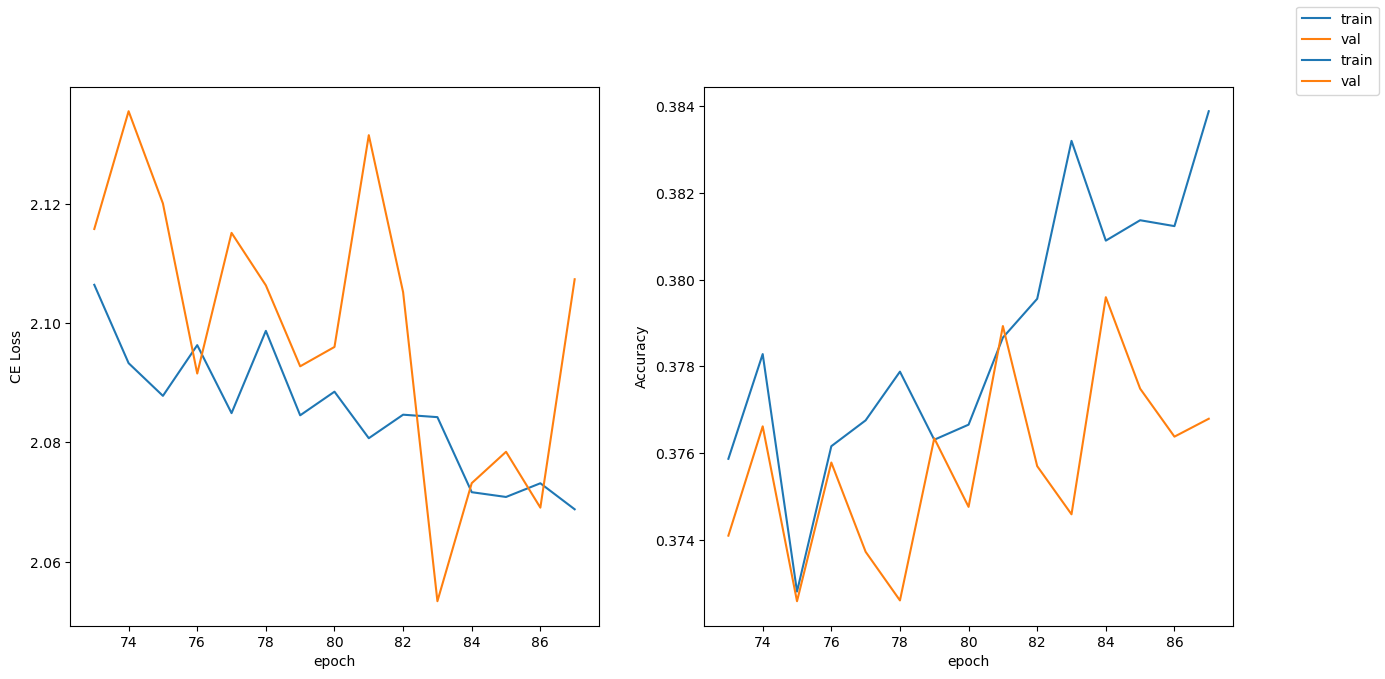

Epoch 87.
Train loss 2.0687995844698968. Train accuracy 0.3838825225830078.
Test loss 2.1073584159215293. Test accuracy 0.3767944574356079


In [18]:
train(model, opt, batch_size=512, epochs=15, starting_epoch=72, best_acc=0.376)

### Prediction part

Prepare result file and send it to Yandex.Contest

In [39]:
# feats.reshape(1, FEATS, -1).shape

In [20]:
model.eval()
# del(trainset)
testset = Dataset('eval', DATADIR, transforms, read_labels=False)

result = []
for idx, ytid in tqdm.tqdm(enumerate(testset._ytids)):
    feats, _ = testset[idx]
    predict = torch.argmax(model.forward(feats.reshape(1, FEATS, -1).to(DEVICE)), dim=1).item()
    result.append((ytid, trainset._idx_to_label[predict]))
pd.DataFrame(result, columns=['YTID', 'label']).to_csv('result.tsv', sep='\t', index=False)

0it [00:00, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [17]:
del(testset)

In [ ]:
# torch.save(model.state_dict(), "checkpoint_10.pth")

In [28]:
# save_cp(model, opt, 42)